## Categorical Modelling

In [1]:
from nilearn import plotting
%matplotlib inline
import os
import json
from nipype.interfaces import fsl 
from nipype.interfaces import spm
from nipype.interfaces.spm import (Realign, SliceTiming, Coregister,  NewSegment,  Normalize12, Smooth)
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces import matlab as mlab
from nipype.interfaces.io import SelectFiles, DataSink
import nipype.interfaces.utility as util 
from nipype.algorithms import rapidart as ra
from nipype.interfaces.utility import Function, IdentityInterface
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio
from nipype.interfaces.base import Bunch
from nipype import DataGrabber, Workflow, Node
from scipy.io.matlab import loadmat

In [2]:
# necessary to let nipype know about matlab path

In [3]:
spm.SPMCommand.set_mlab_paths(paths=os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')), matlab_cmd='/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB -nodesktop -nosplash')

stty: 'standard input': Inappropriate ioctl for device


In [4]:
mlab.MatlabCommand.set_default_matlab_cmd("/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB  -nodesktop -nosplash")
mlab.MatlabCommand.set_default_paths(os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')))

In [5]:
# spm.SPMCommand().version

In [6]:
fsl.FSLCommand.set_default_output_type('NIFTI')

In [7]:
base_dir = os.path.join(os.environ['HOME'], 'spmbasics/data/')

In [8]:
experiment_dir = os.path.join(base_dir, 'output')
data_dir = os.path.abspath(os.path.join(base_dir, 'face_rep'))
output_dir = 'nipype'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['M03953']

# TR of functional images
TR = 2.


# Smoothing width used during preprocessing
fwhm = [8]

In [9]:
# add how to refer sots

In [10]:
#mat0 = mat = loadmat(os.path.join(data_dir, "sots.mat"), mat_dtype=True, matlab_compatible=True, struct_as_record=True)

NOT WORKING: https://nipype.readthedocs.io/en/latest/users/examples/fmri_spm_face.html

In [11]:
#from scipy.io.matlab import loadmat
#mat = loadmat(os.path.join(data_dir, "sots.mat"), struct_as_record=False)
#sot = mat['sot'][0]
#itemlag = mat['itemlag'][0]

#subjectinfo = [
#    Bunch(
#        conditions=['N1', 'N2', 'F1', 'F2'],
#        onsets=[sot[0], sot[1], sot[2], sot[3]],
#        durations=[[0], [0], [0], [0]],
#        amplitudes=None,
#        tmod=None,
#        pmod=None,
#        regressor_names=None,
#        regressors=None)
#]

In [12]:
mat = loadmat(os.path.join(data_dir, "sots.mat"), mat_dtype=True, matlab_compatible=True, struct_as_record=True, simplify_cells=True)
#sot = mat['sot'][1]

#itemlag = mat['itemlag'][0]
#onsets=[sot[0], sot[1], sot[2], sot[3]],


In [13]:
mat = loadmat(os.path.join(data_dir, "sots.mat"), mat_dtype=True, matlab_compatible=True, struct_as_record=True, simplify_cells=True)
subjectinfo = [
    Bunch(
        conditions=['N1', 'N2', 'F1', 'F2'],
        onsets=[ mat['sot'][0], mat['sot'][1],  mat['sot'][2],  mat['sot'][3]],
        durations=[[0], [0], [0], [0]],
        amplitudes=None,
        tmod=None,
        pmod=None,
        regressor_names=None,
        regressors=None)
]

In [14]:
# design matrix setting

In [15]:
cond1 = ('positive effect of condition', 'T',
         ['N1', 'N2', 'F1', 'F2'], [1, 1, 1, 1])
cond2 = ('positive effect of condition_dtemo', 'T',
          ['N1', 'N2', 'F1', 'F2'], [1, 1, 1, 1])
cond3 = ('positive effect of condition_ddisp', 'T',
          ['N1', 'N2', 'F1', 'F2'], [1, 1, 1, 1])
# non-famous > famous
fam1 = ('positive effect of Fame', 'T',
        ['N1', 'N2', 'F1', 'F2'], [1, 1, -1, -1])
fam2 = ('positive effect of Fame_dtemp', 'T',
        ['N1', 'N2', 'F1', 'F2'], [1, 1, -1, -1])
fam3 = ('positive effect of Fame_ddisp', 'T',
        ['N1', 'N2', 'F1', 'F2'], [1, 1, -1, -1])
# rep1 > rep2
rep1 = ('positive effect of Rep', 'T',
        ['N1', 'N2', 'F1', 'F2'], [1, -1, 1, -1])
rep2 = ('positive effect of Rep_dtemp', 'T',
        ['N1', 'N2', 'F1', 'F2'], [1, -1, 1, -1])
rep3 = ('positive effect of Rep_ddisp', 'T',
        ['N1', 'N2', 'F1', 'F2'], [1, -1, 1, -1])
int1 = ('positive interaction of Fame x Rep', 'T',
        ['N1', 'N2', 'F1', 'F2'], [-1, -1, -1, 1])
int2 = ('positive interaction of Fame x Rep_dtemp', 'T',
        ['N1', 'N2', 'F1', 'F2'], [1, -1, -1, 1])
int3 = ('positive interaction of Fame x Rep_ddisp', 'T',
        ['N1', 'N2', 'F1', 'F2'], [1, -1, -1, 1])

contf1 = ['average effect condition', 'F', [cond1, cond2, cond3]]
contf2 = ['main effect Fam', 'F', [fam1, fam2, fam3]]
contf3 = ['main effect Rep', 'F', [rep1, rep2, rep3]]
contf4 = ['interaction: Fam x Rep', 'F', [int1, int2, int3]]
contrast_list = [
    cond1, cond2, cond3, fam1, fam2, fam3, rep1, rep2, rep3, int1, int2, int3,
    contf1, contf2, contf3, contf4
]

In [16]:
# SpecifyModel - Generates SPM-specific Model
specifymodel = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='scans',
                                 output_units='scans',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128,
                                 subject_info = subjectinfo),
                 name="specifymodel")

# Level1Design - Generates an SPM design matrix same as the first level tutorial
eventcategorical = Node(Level1Design(bases={'hrf': {'derivs': [1, 1]}},
                                 timing_units='scans',
                                 interscan_interval=TR,
                                 volterra_expansion_order=1, # no model interction
                                 flags={'mthresh': 0.8},
                                 global_intensity_normalization='none',
                                 microtime_onset=12,
                                 microtime_resolution=24,
                                 #factor_info = [dict(name = 'Fame', levels = 2), # figure out factorized output names
                                 #               dict(name = 'Rep', levels = 2)],
                                 model_serial_correlations='AR(1)'), #matlabbatch{1}.spm.stats.fmri_spec.cvi = 'AR(1)';
                    name="eventcategorical")

# EstimateModel - estimate the parameters of the model
categoricalestimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      write_residuals=False, 
                      name="categoricalestimate")

# EstimateContrast - estimates contrasts
categoricalconest = Node(EstimateContrast(contrasts = contrast_list),
                    use_derivs=True, 
                    name="categoricalconest")

In [17]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]


templates = {'func': os.path.join(output_dir, 'event_preproc', '_subject_id_{subject_id}',
                         'swars{subject_id}_0005_*.img'),#sM03953_0005_*.img
             'mc_param': os.path.join(output_dir, 'event_preproc', '_subject_id_{subject_id}',
                         'rp_s{subject_id}_0005_0006.txt')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

In [18]:
def makelist(item):
    return [item] # look how similar thing incoorporated.

In [20]:
# Initiation of the 1st-level analysis workflow
event_cat = Workflow(name='event_cat')
event_cat.base_dir = os.path.join(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
event_cat.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                    (infosource, categoricalconest, [('contrasts', 'contrasts')]),
                    (selectfiles, specifymodel, [(('func', makelist),  'functional_runs')]), # [(('smooth.smoothed_files',makelist), 'modelspec.functional_runs')])])

                    (selectfiles, specifymodel, [('mc_param', 'realignment_parameters')]),
                    (specifymodel, eventcategorical, [('session_info','session_info')]),
                    (eventcategorical, categoricalestimate, [('spm_mat_file','spm_mat_file')]),                    
                    (categoricalestimate, categoricalconest, [('spm_mat_file','spm_mat_file'),
                                                              ('beta_images','beta_images'),
                                                              ('residual_image', 'residual_image')]),
                    (categoricalestimate, datasink, [('mask_image','event_cat.@mask_image'),
                                                    ('beta_images','event_cat.@beta_images'),
                                                    ('residual_images','event_cat.@residual_images'),
                                                    ('residual_image','event_cat.@residual_image'),
                                                    ('RPVimage', 'event_cat.@RPVimage')]),
                    (categoricalconest, datasink, [('spm_mat_file', 'event_cat.@spm_mat'),
                                                   ('spmT_images', 'event_cat.@T'),
                                                   ('con_images', 'event_cat.@con'),
                                                   ('spmF_images', 'event_cat.@F'),
                                                   ('ess_images', 'event_cat.@ess')]),
                    ])

In [21]:
event_cat.write_graph(graph2use='colored', format='png', dotfilename='colored_cat.dot', simple_form=True)

240528-10:41:56,222 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/event_cat/colored_cat.png (graph2use=colored, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/event_cat/colored_cat.png'

In [22]:
event_cat.write_graph(graph2use='flat', format='png', dotfilename='flat_cat.dot', simple_form=True)

240528-10:41:57,597 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/event_cat/flat_cat.png (graph2use=flat, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/event_cat/flat_cat.png'

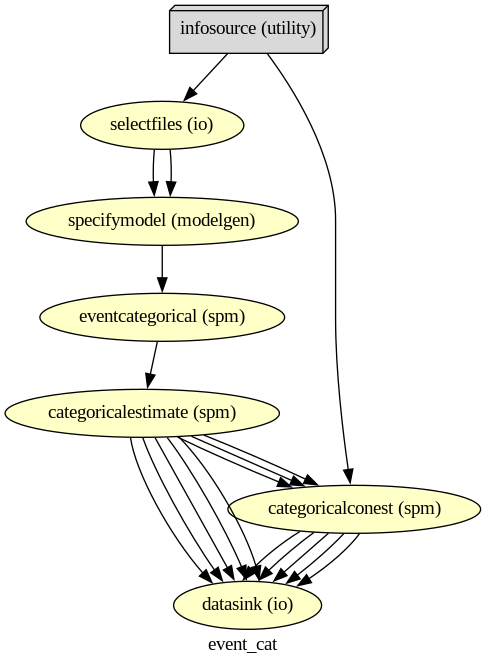

In [23]:
# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(event_cat.base_dir, 'event_cat', 'colored_cat.png'))

In [24]:
event_cat.run('MultiProc', plugin_args={'n_procs': 4})

240528-10:42:02,390 nipype.workflow INFO:
	 Workflow event_cat settings: ['check', 'execution', 'logging', 'monitoring']
240528-10:42:02,397 nipype.workflow INFO:
	 Running in parallel.
240528-10:42:02,398 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240528-10:42:02,471 nipype.workflow INFO:
	 [Node] Setting-up "event_cat.selectfiles" in "/home/matay/spmbasics/data/output/workingdir/event_cat/_subject_id_M03953/selectfiles".
240528-10:42:02,479 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
240528-10:42:02,490 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.008862s.
240528-10:42:04,403 nipype.workflow INFO:
	 [Job 0] Completed (event_cat.selectfiles).
240528-10:42:04,408 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240528-10:42:04,480 nipype.workflow INFO:
	 [Node] S

stty: 'standard input': Inappropriate ioctl for device


240528-10:42:25,434 nipype.workflow INFO:
	 [Node] Finished "eventcategorical", elapsed time 12.455252s.


stty: 'standard input': Inappropriate ioctl for device


240528-10:42:26,424 nipype.workflow INFO:
	 [Job 2] Completed (event_cat.eventcategorical).
240528-10:42:26,429 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240528-10:42:26,496 nipype.workflow INFO:
	 [Node] Setting-up "event_cat.categoricalestimate" in "/home/matay/spmbasics/data/output/workingdir/event_cat/_subject_id_M03953/categoricalestimate".
240528-10:42:26,502 nipype.workflow INFO:
	 [Node] Executing "categoricalestimate" <nipype.interfaces.spm.model.EstimateModel>
240528-10:42:28,425 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.57/13.77, Free processors: 3/4.
                     Currently running:
                       * event_cat.categoricalestimate


stty: 'standard input': Inappropriate ioctl for device


240528-10:42:49,577 nipype.workflow INFO:
	 [Node] Finished "categoricalestimate", elapsed time 17.331593s.


stty: 'standard input': Inappropriate ioctl for device


240528-10:42:50,448 nipype.workflow INFO:
	 [Job 3] Completed (event_cat.categoricalestimate).
240528-10:42:50,452 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240528-10:42:50,510 nipype.workflow INFO:
	 [Node] Setting-up "event_cat.categoricalconest" in "/home/matay/spmbasics/data/output/workingdir/event_cat/_subject_id_M03953/categoricalconest".
240528-10:42:50,534 nipype.workflow INFO:
	 [Node] Executing "categoricalconest" <nipype.interfaces.spm.model.EstimateContrast>
240528-10:42:52,450 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.57/13.77, Free processors: 3/4.
                     Currently running:
                       * event_cat.categoricalconest


stty: 'standard input': Inappropriate ioctl for device


240528-10:43:10,412 nipype.workflow INFO:
	 [Node] Finished "categoricalconest", elapsed time 12.873159s.
240528-10:43:10,466 nipype.workflow INFO:
	 [Job 4] Completed (event_cat.categoricalconest).
240528-10:43:10,470 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240528-10:43:10,548 nipype.workflow INFO:
	 [Node] Setting-up "event_cat.datasink" in "/home/matay/spmbasics/data/output/workingdir/event_cat/_subject_id_M03953/datasink".
240528-10:43:10,558 nipype.workflow INFO:
	 [Node] Executing "datasink" <nipype.interfaces.io.DataSink>


stty: 'standard input': Inappropriate ioctl for device


240528-10:43:10,565 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.005288s.
240528-10:43:12,468 nipype.workflow INFO:
	 [Job 5] Completed (event_cat.datasink).
240528-10:43:12,472 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
